In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import random
from tqdm import tqdm


In [2]:
SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)


In [3]:
BASE_DIR = Path.cwd()
DATASET_PATH = BASE_DIR/ 'dataset'
CATEGORIES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
TARGET_COUNT = 700


In [4]:
def getImages(categoryPath):
    return list(categoryPath.glob('*.jpg'))


def printCategoryCounts():
    print("\nImage counts per category:")
    print("-" * 30)
    for categoryName in CATEGORIES:
        categoryPath = DATASET_PATH / categoryName
        imageCount = len(getImages(categoryPath))
        print(f"{categoryName:15s}: {imageCount} images")


def validateAndCleanDataset():
    if not DATASET_PATH.exists():
        raise FileNotFoundError(f"Dataset not found at: {DATASET_PATH}")
    print("Validating dataset for corrupted images...")
    categoryDirectories = [directory for directory in DATASET_PATH.iterdir() if directory.is_dir()]
    print(f"Found {len(categoryDirectories)} categories: {[category.name for category in categoryDirectories]}\n")
    totalRemovedImages = 0
    for categoryDirectory in sorted(categoryDirectories):
        imageFiles = [file for file in categoryDirectory.iterdir() if file.is_file()]
        removedCount = 0
        for imagePath in imageFiles:
            if cv2.imread(str(imagePath)) is None:
                print(f"Removing: {imagePath.name} as it is corrupted.")
                try:
                    os.remove(imagePath)
                    removedCount += 1
                except Exception as error:
                    print(f"Warning: Could not remove: {error}")
        numberOfValidImages = len(imageFiles) - removedCount
        print(f"{categoryDirectory.name}: {numberOfValidImages}/{len(imageFiles)} valid images")
        totalRemovedImages += removedCount
    print(f"\nValidation complete. Removed {totalRemovedImages} corrupted file(s).")
    printCategoryCounts()


def augmentImage(image):
    height, width = image.shape[:2]
    center = (width / 2, height / 2)
    augmentations = [
        cv2.flip(image, 1),  # Horizontal flip
        cv2.flip(image, 0),  # Vertical flip
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 90, 1.0), (width, height)), # 90 degrees
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 180, 1.0), (width, height)), # 180 degrees
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 270, 1.0), (width, height)), # 270 degrees
        cv2.convertScaleAbs(image, alpha=1.3, beta=30),   # Brightness +30
        cv2.convertScaleAbs(image, alpha=0.7, beta=-30),  # Brightness -30
        cv2.GaussianBlur(image, (5, 5), 0),               # Gaussian blur 5x5
    ]
    # Zoom crop
    scale = 1.2
    newHeight, newWidth = int(height * scale), int(width * scale)
    resized = cv2.resize(image, (newWidth, newHeight))
    startHeight, startWidth = (newHeight - height) // 2, (newWidth - width) // 2
    augmentations.append(resized[startHeight:startHeight + height, startWidth:startWidth + width])
    return augmentations


def augmentDataset():
    print(f"\nAugmenting images to reach {TARGET_COUNT} per category...")
    random.seed(SEED)  
    for categoryName in CATEGORIES:
        categoryPath = DATASET_PATH / categoryName
        imagePaths = sorted(getImages(categoryPath))
        currentImageCount = len(imagePaths)
        imagesNeeded = TARGET_COUNT - currentImageCount
        print(f"\n{categoryName}: {currentImageCount} images", end="")
        if imagesNeeded <= 0:
            print(" - Already sufficient")
            continue
        print(f" (Need {imagesNeeded} more)")
        # Load original images using tqdm for progress
        originalImages = [(cv2.imread(str(imageFile)), imageFile.stem) for imageFile in tqdm(imagePaths, desc="Loading")]
        originalImages = [(image, name) for image, name in originalImages]
        # Generate augmented images
        generatedCount = 0
        while generatedCount < imagesNeeded:
            image, imageName = random.choice(originalImages)
            for augmentationIndex, augmentedImage in enumerate(augmentImage(image)):
                if generatedCount >= imagesNeeded:
                    break
                savePath = categoryPath / f"{imageName}_augmented_{generatedCount}_{augmentationIndex}.jpg"
                cv2.imwrite(str(savePath), augmentedImage)
                generatedCount += 1
        print(f"Generated {generatedCount} augmented images")
    print("\n" + "=" * 50)
    print("Augmentation complete.")
    printCategoryCounts()



In [5]:
validateAndCleanDataset()


Validating dataset for corrupted images...
Found 6 categories: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

cardboard: 700/700 valid images
glass: 700/700 valid images
metal: 700/700 valid images
paper: 700/700 valid images
plastic: 700/700 valid images
trash: 700/700 valid images

Validation complete. Removed 0 corrupted file(s).

Image counts per category:
------------------------------
cardboard      : 700 images
glass          : 700 images
metal          : 700 images
paper          : 700 images
plastic        : 700 images
trash          : 700 images


In [6]:
augmentDataset()



Augmenting images to reach 700 per category...

cardboard: 700 images - Already sufficient

glass: 700 images - Already sufficient

metal: 700 images - Already sufficient

paper: 700 images - Already sufficient

plastic: 700 images - Already sufficient

trash: 700 images - Already sufficient

Augmentation complete.

Image counts per category:
------------------------------
cardboard      : 700 images
glass          : 700 images
metal          : 700 images
paper          : 700 images
plastic        : 700 images
trash          : 700 images


In [21]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from knn_classifier import KNNMaterialClassifier
from SVM_classifier import SVMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import shutil


# # Set seeds for reproducibility
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
# Set environment variable to avoid memory fragmentation
  os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Clear CUDA cache if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Initial GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB allocated")

# Image size for DenseNet-201
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 60
LEARNING_RATE = 0.0001

# Define preprocessing transforms for DenseNet-201
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Initial GPU Memory: 0.22 GB allocated


In [8]:
# ============================================================================
# PREPROCESS AND SAVE IMAGES TO DISK (for faster loading)
# ============================================================================
print("\n" + "=" * 80)
print("PREPROCESSING IMAGES AND SAVING TO DISK")
print("=" * 80)

# Define paths for preprocessed data
PREPROCESSED_DIR = BASE_DIR / 'preprocessed_dataset'
PREPROCESSED_TRAIN_DIR = PREPROCESSED_DIR / 'train'
PREPROCESSED_VAL_DIR = PREPROCESSED_DIR / 'val'

# Clear and create preprocessed directories
if PREPROCESSED_DIR.exists():
    print(f"Removing existing preprocessed directory: {PREPROCESSED_DIR}")
    shutil.rmtree(PREPROCESSED_DIR)

PREPROCESSED_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
PREPROCESSED_VAL_DIR.mkdir(parents=True, exist_ok=True)

# Create category subdirectories
for category in CATEGORIES:
    (PREPROCESSED_TRAIN_DIR / category).mkdir(exist_ok=True)
    (PREPROCESSED_VAL_DIR / category).mkdir(exist_ok=True)

print(f"Created preprocessed directories:")
print(f"  Train: {PREPROCESSED_TRAIN_DIR}")
print(f"  Val:   {PREPROCESSED_VAL_DIR}")

# Collect all image paths and labels
print("\nCollecting image paths from augmented dataset...")
image_paths = []
labels = []
label_to_idx = {cat: idx for idx, cat in enumerate(CATEGORIES)}

for category_dir in DATASET_PATH.iterdir():
    if category_dir.is_dir() and category_dir.name in CATEGORIES:
        category = category_dir.name
        for img_path in category_dir.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in {".jpg"}:
                image_paths.append(str(img_path))
                labels.append(label_to_idx[category])

print(f"Total images found: {len(image_paths)}")
print(f"Classes: {CATEGORIES}")
print(f"Label mapping: {label_to_idx}")

# Split into train and validation sets
from sklearn.model_selection import train_test_split as sklearn_split
train_paths, val_paths, train_labels, val_labels = sklearn_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nDataset split:")
print(f"  Training samples: {len(train_paths)}")
print(f"  Validation samples: {len(val_paths)}")

# Function to preprocess and save a single image
def preprocess_and_save_image(img_path, label, save_dir, transform, idx):
    """Preprocess an image and save as tensor"""
    try:
        # Load image
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Warning: Could not load {img_path}")
            return False

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        # Apply transform
        img_tensor = transform(img)

        # Save as .pt file
        category_name = CATEGORIES[label]
        filename = Path(img_path).stem + '.pt'
        save_path = save_dir / category_name / filename
        torch.save(img_tensor, save_path)

        return True
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return False

# Preprocess and save training images
print("\n" + "-" * 80)
print("Preprocessing and saving TRAINING images...")
print("-" * 80)
train_success = 0
for idx, (img_path, label) in enumerate(tqdm(zip(train_paths, train_labels),
                                               total=len(train_paths),
                                               desc="Train images")):
    if preprocess_and_save_image(img_path, label, PREPROCESSED_TRAIN_DIR, train_transform, idx):
        train_success += 1

print(f"Successfully preprocessed and saved {train_success}/{len(train_paths)} training images")

# Preprocess and save validation images
print("\n" + "-" * 80)
print("Preprocessing and saving VALIDATION images...")
print("-" * 80)
val_success = 0
for idx, (img_path, label) in enumerate(tqdm(zip(val_paths, val_labels),
                                              total=len(val_paths),
                                              desc="Val images")):
    if preprocess_and_save_image(img_path, label, PREPROCESSED_VAL_DIR, val_transform, idx):
        val_success += 1

print(f"Successfully preprocessed and saved {val_success}/{len(val_paths)} validation images")

print("\n" + "=" * 80)
print("PREPROCESSING COMPLETE!")
print("=" * 80)
print(f"Preprocessed images saved to: {PREPROCESSED_DIR}")
print(f"  Train: {train_success} images")
print(f"  Val:   {val_success} images")
print("\nThese preprocessed tensors can now be loaded directly for faster training.")
print("=" * 80)



PREPROCESSING IMAGES AND SAVING TO DISK
Removing existing preprocessed directory: /home/omar/PycharmProjects/ML_FCAI/preprocessed_dataset
Created preprocessed directories:
  Train: /home/omar/PycharmProjects/ML_FCAI/preprocessed_dataset/train
  Val:   /home/omar/PycharmProjects/ML_FCAI/preprocessed_dataset/val

Total images found: 4200
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Label mapping: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

Dataset split:
  Training samples: 3360
  Validation samples: 840

--------------------------------------------------------------------------------
Preprocessing and saving TRAINING images...
--------------------------------------------------------------------------------


Train images: 100%|██████████████| 3360/3360 [00:18<00:00, 178.67it/s]


Successfully preprocessed and saved 3360/3360 training images

--------------------------------------------------------------------------------
Preprocessing and saving VALIDATION images...
--------------------------------------------------------------------------------


Val images: 100%|██████████████████| 840/840 [00:04<00:00, 189.78it/s]

Successfully preprocessed and saved 840/840 validation images

PREPROCESSING COMPLETE!
Preprocessed images saved to: /home/omar/PycharmProjects/ML_FCAI/preprocessed_dataset
  Train: 3360 images
  Val:   840 images

These preprocessed tensors can now be loaded directly for faster training.


In [9]:
# ============================================================================
# DATASET CLASS FOR LOADING PREPROCESSED TENSORS
# ============================================================================

import pickle
from concurrent.futures import ThreadPoolExecutor

# Custom Dataset class for loading preprocessed tensors
class PreprocessedTensorDataset(Dataset):
    """Dataset that loads preprocessed tensor files from disk with caching"""
    def __init__(self, preprocessed_dir, categories, cache_file=None):
        self.preprocessed_dir = preprocessed_dir
        self.label_to_idx = {cat: idx for idx, cat in enumerate(categories)}

        # Generate cache filename if not provided
        if cache_file is None:
            cache_file = preprocessed_dir.parent / f"{preprocessed_dir.name}_cache.pkl"

        # Try to load from cache first
        if cache_file.exists():
            print(f"Loading cached paths from {cache_file}...")
            with open(cache_file, 'rb') as f:
                cache_data = pickle.load(f)
                self.tensor_paths = cache_data['tensor_paths']
                self.labels = cache_data['labels']
            print(f"✓ Loaded {len(self.tensor_paths)} cached paths in seconds")
        else:
            print(f"Cache not found. Collecting tensor paths from {preprocessed_dir}...")
            self.tensor_paths = []
            self.labels = []

            # Parallel path collection for speed
            def collect_category_paths(category):
                category_dir = preprocessed_dir / category
                if not category_dir.exists():
                    return [], []
                paths = list(category_dir.glob('*.pt'))
                labels = [self.label_to_idx[category]] * len(paths)
                return paths, labels

            # Use ThreadPoolExecutor for parallel I/O
            with ThreadPoolExecutor(max_workers=len(categories)) as executor:
                results = list(executor.map(collect_category_paths, categories))

            # Flatten results
            for paths, labels in results:
                self.tensor_paths.extend(paths)
                self.labels.extend(labels)

            print(f"✓ Collected {len(self.tensor_paths)} tensor paths")

            # Save to cache
            print(f"Saving paths to cache: {cache_file}")
            cache_data = {
                'tensor_paths': self.tensor_paths,
                'labels': self.labels
            }
            with open(cache_file, 'wb') as f:
                pickle.dump(cache_data, f, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"✓ Cache saved!")

    def __len__(self):
        return len(self.tensor_paths)

    def __getitem__(self, idx):
        tensor_path = self.tensor_paths[idx]
        label = self.labels[idx]

        # Load preprocessed tensor with weights_only=True for security and speed
        img_tensor = torch.load(tensor_path, map_location='cpu', weights_only=True)

        return img_tensor, label

# Custom Dataset class (original - for comparison)
class WasteDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, label


In [10]:
# ============================================================================
# CREATE DATALOADERS FROM PREPROCESSED TENSORS
# ============================================================================
print("\n" + "=" * 80)
print("CREATING DATALOADERS FROM PREPROCESSED TENSORS")
print("=" * 80)

# Create datasets from preprocessed tensors with caching
train_dataset = PreprocessedTensorDataset(
    PREPROCESSED_TRAIN_DIR,
    CATEGORIES,
    cache_file=PREPROCESSED_DIR / 'train_cache.pkl'
)
val_dataset = PreprocessedTensorDataset(
    PREPROCESSED_VAL_DIR,
    CATEGORIES,
    cache_file=PREPROCESSED_DIR / 'val_cache.pkl'
)

print(f"\nDataset sizes:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")

# Create dataloaders with optimized settings
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,  # Keep workers alive between epochs
    prefetch_factor=3         # Prefetch 3 batches per worker
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=3
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Workers: 6 with persistent_workers=True and prefetch_factor=3")
print("\n✓ DataLoaders are now loading preprocessed tensors directly from disk!")
print("  This will be much faster than loading and preprocessing images on-the-fly.")
print("  Path caching makes subsequent runs nearly instant!")
print("=" * 80)



CREATING DATALOADERS FROM PREPROCESSED TENSORS
Cache not found. Collecting tensor paths from /home/omar/PycharmProjects/ML_FCAI/preprocessed_dataset/train...
✓ Collected 3360 tensor paths
Saving paths to cache: /home/omar/PycharmProjects/ML_FCAI/preprocessed_dataset/train_cache.pkl
✓ Cache saved!
Cache not found. Collecting tensor paths from /home/omar/PycharmProjects/ML_FCAI/preprocessed_dataset/val...
✓ Collected 840 tensor paths
Saving paths to cache: /home/omar/PycharmProjects/ML_FCAI/preprocessed_dataset/val_cache.pkl
✓ Cache saved!

Dataset sizes:
  Training: 3360 samples
  Validation: 840 samples

DataLoaders created:
  Train batches: 210
  Val batches: 53
  Batch size: 16
  Workers: 6 with persistent_workers=True and prefetch_factor=3

✓ DataLoaders are now loading preprocessed tensors directly from disk!
  This will be much faster than loading and preprocessing images on-the-fly.
  Path caching makes subsequent runs nearly instant!


In [11]:

# Load pre-trained DenseNet-201 and modify for our task
print("\nLoading pre-trained DenseNet-201 model from PyTorch...")
densenet_model = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)

# Replace the classifier for our 6 classes
num_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_features, len(CATEGORIES))

densenet_model = densenet_model.to(device)
print(f"DenseNet-201 loaded with {len(CATEGORIES)} output classes")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Gradient accumulation steps (simulate batch size of 32 with 8*4)
ACCUMULATION_STEPS = 4

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    optimizer.zero_grad()  # Reset gradients once at the start

    for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss / ACCUMULATION_STEPS  # Normalize loss
        loss.backward()

        # Update weights every ACCUMULATION_STEPS
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * ACCUMULATION_STEPS  # Denormalize for logging
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Store predictions and labels for F1 score
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Clear cache periodically
        if (batch_idx + 1) % 10 == 0:
            torch.cuda.empty_cache()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    return epoch_loss, epoch_acc, epoch_f1

# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc="Validation")):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store predictions and labels for F1 score
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Clear cache periodically
            if (batch_idx + 1) % 10 == 0:
                torch.cuda.empty_cache()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    return epoch_loss, epoch_acc, epoch_f1

# Train the model
print("\n" + "=" * 60)
print("Training DenseNet-201 on Waste Classification Dataset")
print("=" * 60)

best_val_acc = 0.0
best_val_f1 = 0.0
train_history = {'loss': [], 'acc': [], 'f1': []}
val_history = {'loss': [], 'acc': [], 'f1': []}

# Early stopping parameters (based on validation accuracy or F1 score)
patience = 5
counter = 0
best_epoch = 0
best_combined_metric = 0.0  # Track best combined score (acc + f1)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 40)

    train_loss, train_acc, train_f1 = train_epoch(densenet_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = validate_epoch(densenet_model, val_loader, criterion, device)

    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)
    train_history['f1'].append(train_f1)
    val_history['loss'].append(val_loss)
    val_history['acc'].append(val_acc)
    val_history['f1'].append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}% | Val F1:   {val_f1:.2f}%")

    # Track if any metric improved
    improved = False

    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(densenet_model.state_dict(), 'best_densenet201.pth')
        print(f"✓ Best model (by accuracy) saved with Val Acc: {val_acc:.2f}%")
        improved = True

    # Save best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(densenet_model.state_dict(), 'best_densenet201.pth')
        print(f"✓ Best model (by F1) saved with Val F1: {val_f1:.2f}%")
        improved = True

    # Save overall best model based on combined metric (average of accuracy and F1)
    combined_metric = (val_acc + val_f1) / 2.0
    if combined_metric > best_combined_metric:
        best_combined_metric = combined_metric
        torch.save(densenet_model.state_dict(), 'best_densenet201.pth')
        print(f"✓ Overall best model saved (Combined: {combined_metric:.2f}%)")

    # Early stopping based on validation accuracy or F1 score improvement
    if improved:
        counter = 0
        best_epoch = epoch
        print(f"✓ Metrics improved! Resetting early stopping counter.")
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} out of {patience} (no improvement in Val Acc or F1)")
        if counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}.")
            print(f"No improvement in validation accuracy or F1 score for {patience} epochs.")
            print(f"Best epoch was {best_epoch+1} with Val Acc: {best_val_acc:.2f}%, Val F1: {best_val_f1:.2f}%")
            break

    scheduler.step()

print("\n" + "=" * 60)
print(f"Training complete!")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Best validation F1 score: {best_val_f1:.2f}%")
print(f"  Best combined metric: {best_combined_metric:.2f}%")
print(f"  Best epoch: {best_epoch + 1}")
print("=" * 60)


Loading pre-trained DenseNet-201 model from PyTorch...
DenseNet-201 loaded with 6 output classes

Training DenseNet-201 on Waste Classification Dataset

Epoch 1/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 14.51it/s]


Train Loss: 0.7347 | Train Acc: 77.08% | Train F1: 77.17%
Val Loss:   0.1931 | Val Acc:   94.88% | Val F1:   94.89%
✓ Best model (by accuracy) saved with Val Acc: 94.88%
✓ Best model (by F1) saved with Val F1: 94.89%
✓ Overall best model saved (Combined: 94.88%)
✓ Metrics improved! Resetting early stopping counter.

Epoch 2/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.84it/s]


Train Loss: 0.1749 | Train Acc: 95.71% | Train F1: 95.71%
Val Loss:   0.1129 | Val Acc:   96.79% | Val F1:   96.78%
✓ Best model (by accuracy) saved with Val Acc: 96.79%
✓ Best model (by F1) saved with Val F1: 96.78%
✓ Overall best model saved (Combined: 96.78%)
✓ Metrics improved! Resetting early stopping counter.

Epoch 3/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.58it/s]


Train Loss: 0.0692 | Train Acc: 98.78% | Train F1: 98.78%
Val Loss:   0.0857 | Val Acc:   97.26% | Val F1:   97.26%
✓ Best model (by accuracy) saved with Val Acc: 97.26%
✓ Best model (by F1) saved with Val F1: 97.26%
✓ Overall best model saved (Combined: 97.26%)
✓ Metrics improved! Resetting early stopping counter.

Epoch 4/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.75it/s]


Train Loss: 0.0433 | Train Acc: 99.52% | Train F1: 99.52%
Val Loss:   0.0840 | Val Acc:   97.14% | Val F1:   97.14%
EarlyStopping counter: 1 out of 5 (no improvement in Val Acc or F1)

Epoch 5/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.71it/s]


Train Loss: 0.0343 | Train Acc: 99.70% | Train F1: 99.70%
Val Loss:   0.0810 | Val Acc:   97.26% | Val F1:   97.26%
✓ Best model (by F1) saved with Val F1: 97.26%
✓ Overall best model saved (Combined: 97.26%)
✓ Metrics improved! Resetting early stopping counter.

Epoch 6/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.89it/s]


Train Loss: 0.0265 | Train Acc: 99.85% | Train F1: 99.85%
Val Loss:   0.0811 | Val Acc:   97.26% | Val F1:   97.26%
✓ Best model (by F1) saved with Val F1: 97.26%
✓ Overall best model saved (Combined: 97.26%)
✓ Metrics improved! Resetting early stopping counter.

Epoch 7/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.87it/s]


Train Loss: 0.0303 | Train Acc: 99.67% | Train F1: 99.67%
Val Loss:   0.0793 | Val Acc:   97.14% | Val F1:   97.14%
EarlyStopping counter: 1 out of 5 (no improvement in Val Acc or F1)

Epoch 8/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.84it/s]


Train Loss: 0.0271 | Train Acc: 99.82% | Train F1: 99.82%
Val Loss:   0.0807 | Val Acc:   97.14% | Val F1:   97.14%
EarlyStopping counter: 2 out of 5 (no improvement in Val Acc or F1)

Epoch 9/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.86it/s]


Train Loss: 0.0242 | Train Acc: 99.88% | Train F1: 99.88%
Val Loss:   0.0783 | Val Acc:   97.02% | Val F1:   97.02%
EarlyStopping counter: 3 out of 5 (no improvement in Val Acc or F1)

Epoch 10/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.90it/s]


Train Loss: 0.0255 | Train Acc: 99.82% | Train F1: 99.82%
Val Loss:   0.0797 | Val Acc:   97.02% | Val F1:   97.02%
EarlyStopping counter: 4 out of 5 (no improvement in Val Acc or F1)

Epoch 11/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.98it/s]


Train Loss: 0.0228 | Train Acc: 99.88% | Train F1: 99.88%
Val Loss:   0.0793 | Val Acc:   97.38% | Val F1:   97.38%
✓ Best model (by accuracy) saved with Val Acc: 97.38%
✓ Best model (by F1) saved with Val F1: 97.38%
✓ Overall best model saved (Combined: 97.38%)
✓ Metrics improved! Resetting early stopping counter.

Epoch 12/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 17.03it/s]


Train Loss: 0.0252 | Train Acc: 99.85% | Train F1: 99.85%
Val Loss:   0.0800 | Val Acc:   97.02% | Val F1:   97.02%
EarlyStopping counter: 1 out of 5 (no improvement in Val Acc or F1)

Epoch 13/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.93it/s]


Train Loss: 0.0300 | Train Acc: 99.70% | Train F1: 99.70%
Val Loss:   0.0810 | Val Acc:   97.26% | Val F1:   97.26%
EarlyStopping counter: 2 out of 5 (no improvement in Val Acc or F1)

Epoch 14/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 17.03it/s]


Train Loss: 0.0299 | Train Acc: 99.61% | Train F1: 99.61%
Val Loss:   0.0779 | Val Acc:   97.14% | Val F1:   97.14%
EarlyStopping counter: 3 out of 5 (no improvement in Val Acc or F1)

Epoch 15/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.94it/s]


Train Loss: 0.0265 | Train Acc: 99.79% | Train F1: 99.79%
Val Loss:   0.0850 | Val Acc:   97.38% | Val F1:   97.38%
EarlyStopping counter: 4 out of 5 (no improvement in Val Acc or F1)

Epoch 16/60
----------------------------------------


Validation: 100%|█████████████████████| 53/53 [00:03<00:00, 16.92it/s]

Train Loss: 0.0258 | Train Acc: 99.82% | Train F1: 99.82%
Val Loss:   0.0785 | Val Acc:   97.14% | Val F1:   97.14%
EarlyStopping counter: 5 out of 5 (no improvement in Val Acc or F1)

Early stopping triggered at epoch 16.
No improvement in validation accuracy or F1 score for 5 epochs.
Best epoch was 11 with Val Acc: 97.38%, Val F1: 97.38%

Training complete!
  Best validation accuracy: 97.38%
  Best validation F1 score: 97.38%
  Best combined metric: 97.38%
  Best epoch: 11


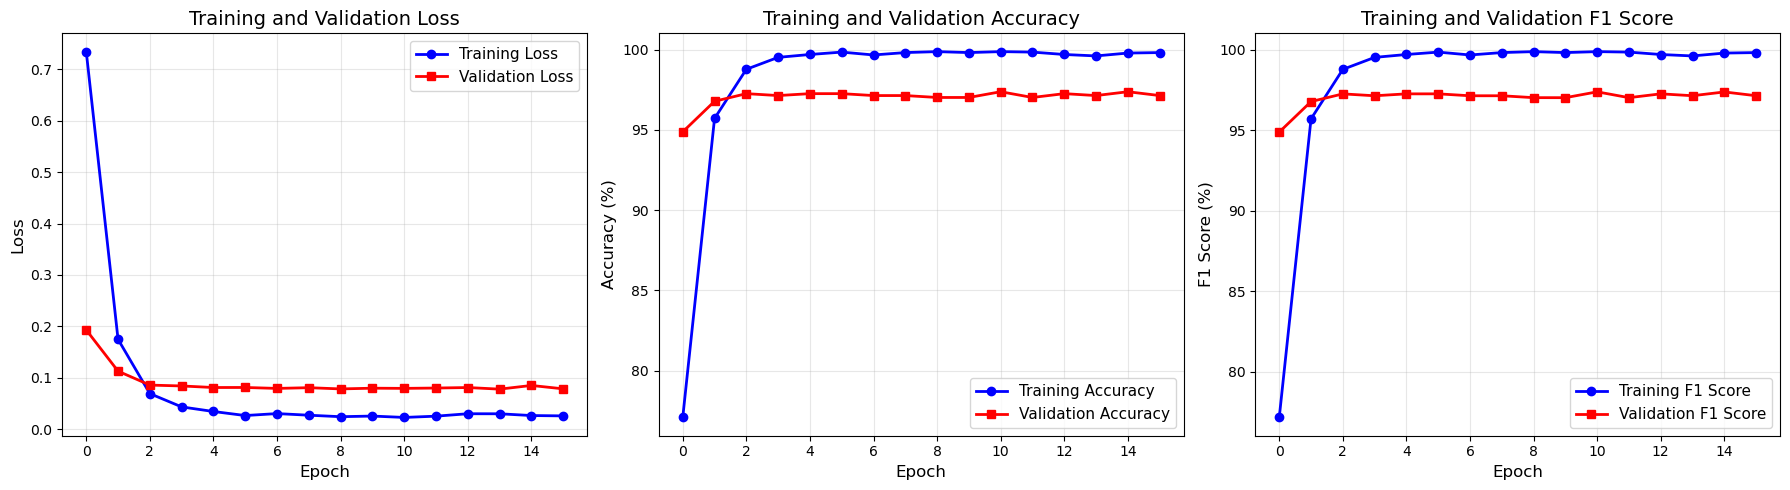


Loading best trained DenseNet-201 model for feature extraction...
CNN Feature Extractor ready. Output shape: (batch_size, 1920)
Feature vector size: 1920 dimensions (DenseNet-201 output)


In [12]:

# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot loss
ax1.plot(train_history['loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
ax1.plot(val_history['loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_history['acc'], 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
ax2.plot(val_history['acc'], 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot F1 score
ax3.plot(train_history['f1'], 'b-o', label='Training F1 Score', linewidth=2, markersize=6)
ax3.plot(val_history['f1'], 'r-s', label='Validation F1 Score', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('F1 Score (%)', fontsize=12)
ax3.set_title('Training and Validation F1 Score', fontsize=14)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Load best model for feature extraction
print("\nLoading best trained DenseNet-201 model for feature extraction...")
densenet_model.load_state_dict(torch.load('best_densenet201.pth'))

# Create feature extractor (remove classifier)
cnn_model = nn.Sequential(
    densenet_model.features,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)
cnn_model = cnn_model.to(device)
cnn_model.eval()  # Set to evaluation mode
print(f"CNN Feature Extractor ready. Output shape: (batch_size, 1920)")

# Define preprocessing for feature extraction
preprocess = val_transform

def extract_cnn_features(img_path):
    """Extract features from an image using pre-trained DenseNet-201."""
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = cnn_model(img_tensor)
        # features shape: (1, 1920)
        features = features.view(-1).cpu().numpy()  # Always flatten to (1920,)
        return features
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None
print(f"Feature vector size: 1920 dimensions (DenseNet-201 output)")

In [13]:
# Rebuild rows from disk
rows = []
for category_dir in DATASET_PATH. iterdir():
    if category_dir. is_dir():
        category = category_dir.name
        for img_path in category_dir.iterdir():
            if img_path.is_file() and img_path.suffix. lower() in {".jpg"}:
                rows.append({"filename": str(img_path), "category": category})

df = pd.DataFrame(rows)
print(f"Total images found: {len(df)}")

# Extract features for all images
features, labels = [], []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting CNN features"):
    feat = extract_cnn_features(row["filename"])
    if feat is not None:
        features.append(feat)
        labels.append(row["category"])

X = np. array(features, dtype=np.float32)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nDataset split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples:   {len(X_test)}")
print(f"  Feature dimensions: {X.shape[1]}")
print(f"  Classes: {list(le.classes_)}")

Total images found: 4200


Extracting CNN features:   0%|       | 5/4200 [00:00<03:51, 18.15it/s]

Extracted feature shape: (1920,)


Extracting CNN features: 100%|████| 4200/4200 [03:13<00:00, 21.67it/s]



Dataset split:
  Training samples: 3360
  Testing samples:   840
  Feature dimensions: 1920
  Classes: [np.str_('cardboard'), np.str_('glass'), np.str_('metal'), np.str_('paper'), np.str_('plastic'), np.str_('trash')]


In [23]:
# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Experiment with different k values
k_values = [1, 3, 5, 7, 9, 11, 15]
results = []

print("=" * 60)
print("KNN Experiments with Different k Values")
print("=" * 60)

for k in k_values:
    knn = KNNMaterialClassifier(k=k, weighting='distance')
    knn.train(X_train_scaled, y_train)

    # Predict with custom KNN
    y_train_pred_temp = np.array([knn.predict(x) for x in X_train_scaled])
    y_test_pred_temp = np.array([knn.predict(x) for x in X_test_scaled])

    # Filter out unknown predictions (class 6) for accuracy calculation
    train_mask = y_train_pred_temp != 6
    test_mask = y_test_pred_temp != 6

    train_acc = accuracy_score(y_train[train_mask], y_train_pred_temp[train_mask]) if train_mask.any() else 0
    test_acc = accuracy_score(y_test[test_mask], y_test_pred_temp[test_mask]) if test_mask.any() else 0

    results.append({'k': k, 'train_acc': train_acc, 'test_acc': test_acc})
    print(f"k={k:2d}  |  Train Accuracy: {train_acc:.4f}  |  Test Accuracy: {test_acc:.4f}")

# Find best k
best_result = max(results, key=lambda x: x['test_acc'])
print("\n" + "=" * 60)
print(f"Best k = {best_result['k']} with Test Accuracy = {best_result['test_acc']:.4f}")
print("=" * 60)


KNN Experiments with Different k Values
k= 1  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9750
k= 3  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9762
k= 5  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9762
k= 7  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9762
k= 9  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9762
k= 11  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9750
k= 15  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9762

Best k = 3 with Test Accuracy = 0.9762


In [30]:
# Train final model with best k
best_k = best_result['k']
knn_best = KNNMaterialClassifier(k=best_k, weighting='distance')
knn_best.train(X_train_scaled, y_train)

# Predictions
y_train_pred = np.array([knn_best.predict(x) for x in X_train_scaled])
y_test_pred = np.array([knn_best.predict(x) for x in X_test_scaled])

# Filter out unknown predictions (class 6) for metrics
train_mask = y_train_pred != 6
test_mask = y_test_pred != 6

# Final accuracies
train_accuracy = accuracy_score(y_train[train_mask], y_train_pred[train_mask])
test_accuracy = accuracy_score(y_test[test_mask], y_test_pred[test_mask])

# Calculate F1 scores
train_f1 = f1_score(y_train[train_mask], y_train_pred[train_mask], average='weighted')
test_f1 = f1_score(y_test[test_mask], y_test_pred[test_mask], average='weighted')
f1_diff = abs(train_f1 - test_f1) * 100  # Convert to percentage

print(f"Final KNN Model (k={best_k})")
print("=" * 60)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:   {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Training F1 Score: {train_f1:.4f} ({train_f1*100:.2f}%)")
print(f"Testing F1 Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"F1 Score Difference: {f1_diff:.2f}%")
print(f"Unknown predictions: Train={np.sum(~train_mask)}, Test={np.sum(~test_mask)}")
print("=" * 60)

# Check for overfitting
if f1_diff <= 3.0:
    print("✓ NO OVERFITTING DETECTED (F1 difference ≤ 3%)")
else:
    print(f"⚠ OVERFITTING DETECTED! (F1 difference = {f1_diff:.2f}% > 3%)")
    print("  The model performs significantly better on training data than test data.")
print("=" * 60)

print("\nClassification Report (Test Set):")
print(classification_report(y_test[test_mask], y_test_pred[test_mask], target_names=le.classes_))

print("\nClassification Report (Train Set):")
print(classification_report(y_train[train_mask], y_train_pred[train_mask], target_names=le.classes_))

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test[test_mask], y_test_pred[test_mask])
print(cm)

# Pretty print confusion matrix
print("\nConfusion Matrix (formatted):")
print(f"{'':15s}", end="")
for cls in le.classes_:
    print(f"{cls:>10s}", end="")
print()
for i, cls in enumerate(le. classes_):
    print(f"{cls:15s}", end="")
    for j in range(len(le.classes_)):
        print(f"{cm[i, j]:10d}", end="")
    print()

Final KNN Model (k=3)
Training Accuracy: 1.0000 (100.00%)
Testing Accuracy:   0.9901 (99.01%)
Training F1 Score: 1.0000 (100.00%)
Testing F1 Score:  0.9901 (99.01%)
F1 Score Difference: 0.99%
Unknown predictions: Train=0, Test=739
✓ NO OVERFITTING DETECTED (F1 difference ≤ 3%)

Classification Report (Test Set):
              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00        18
       glass       0.90      1.00      0.95         9
       metal       1.00      0.90      0.95        10
       paper       1.00      1.00      1.00         8
     plastic       1.00      1.00      1.00         7
       trash       1.00      1.00      1.00        49

    accuracy                           0.99       101
   macro avg       0.98      0.98      0.98       101
weighted avg       0.99      0.99      0.99       101


Classification Report (Train Set):
              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00       560

In [26]:
print("\n" + "=" * 60)
print("SVM Experiments with Different Kernels and Parameters")
print("=" * 60)

# Test different SVM configurations
svm_results = []
svm_configs = [
    {'kernel': 'linear', 'C': 1.0, 'name': 'Linear (C=1.0)'},
    {'kernel': 'linear', 'C': 10.0, 'name': 'Linear (C=10.0)'},
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'name': 'RBF (C=1.0, gamma=scale)'},
    {'kernel': 'rbf', 'C': 10.0, 'gamma': 'scale', 'name': 'RBF (C=10.0, gamma=scale)'},
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'auto', 'name': 'RBF (C=1.0, gamma=auto)'},
]

for config in svm_configs:
    print(f"\nTraining {config['name']}...")
    name = config.pop('name')

    svm = SVMClassifier(**config)
    svm.train_model(X_train_scaled, y_train)

    # Predict with custom SVM
    y_train_pred_temp = np.array([svm.predict_data(x) for x in X_train_scaled])
    y_test_pred_temp = np.array([svm.predict_data(x) for x in X_test_scaled])

    # Filter out unknown predictions (class 6)
    train_mask_temp = y_train_pred_temp != 6
    test_mask_temp = y_test_pred_temp != 6

    train_acc = accuracy_score(y_train[train_mask_temp], y_train_pred_temp[train_mask_temp]) if train_mask_temp.any() else 0
    test_acc = accuracy_score(y_test[test_mask_temp], y_test_pred_temp[test_mask_temp]) if test_mask_temp.any() else 0

    svm_results.append({'name': name, 'train_acc': train_acc, 'test_acc': test_acc, 'config': config})
    print(f"{name:40s}  |  Train Acc: {train_acc:.4f}  |  Test Acc: {test_acc:.4f}")

# Find best SVM configuration
best_svm_result = max(svm_results, key=lambda x: x['test_acc'])
print("\n" + "=" * 60)
print(f"Best SVM: {best_svm_result['name']}")
print(f"Test Accuracy: {best_svm_result['test_acc']:.4f}")
print("=" * 60)



SVM Experiments with Different Kernels and Parameters

Training Linear (C=1.0)...
Linear (C=1.0)                            |  Train Acc: 1.0000  |  Test Acc: 0.9866

Training Linear (C=10.0)...
Linear (C=10.0)                           |  Train Acc: 1.0000  |  Test Acc: 0.9866

Training RBF (C=1.0, gamma=scale)...
RBF (C=1.0, gamma=scale)                  |  Train Acc: 1.0000  |  Test Acc: 0.9867

Training RBF (C=10.0, gamma=scale)...
RBF (C=10.0, gamma=scale)                 |  Train Acc: 1.0000  |  Test Acc: 0.9867

Training RBF (C=1.0, gamma=auto)...
RBF (C=1.0, gamma=auto)                   |  Train Acc: 1.0000  |  Test Acc: 0.9867

Best SVM: RBF (C=1.0, gamma=scale)
Test Accuracy: 0.9867


In [27]:
# Train final SVM model with best configuration
print(f"Training final SVM model: {best_svm_result['name']}")
best_svm = SVMClassifier(**best_svm_result['config'])
best_svm.train_model(X_train_scaled, y_train)

# Predictions
y_train_pred_svm = np.array([best_svm.predict_data(x) for x in X_train_scaled])
y_test_pred_svm = np.array([best_svm.predict_data(x) for x in X_test_scaled])

# Filter out unknown predictions (class 6)
train_mask_svm = y_train_pred_svm != 6
test_mask_svm = y_test_pred_svm != 6

# Final accuracies
train_accuracy_svm = accuracy_score(y_train[train_mask_svm], y_train_pred_svm[train_mask_svm])
test_accuracy_svm = accuracy_score(y_test[test_mask_svm], y_test_pred_svm[test_mask_svm])

# Calculate F1 scores
train_f1_svm = f1_score(y_train[train_mask_svm], y_train_pred_svm[train_mask_svm], average='weighted')
test_f1_svm = f1_score(y_test[test_mask_svm], y_test_pred_svm[test_mask_svm], average='weighted')
f1_diff_svm = abs(train_f1_svm - test_f1_svm) * 100  # Convert to percentage

print(f"\nFinal SVM Model ({best_svm_result['name']})")
print("=" * 60)
print(f"Training Accuracy: {train_accuracy_svm:.4f} ({train_accuracy_svm*100:.2f}%)")
print(f"Testing Accuracy:   {test_accuracy_svm:.4f} ({test_accuracy_svm*100:.2f}%)")
print(f"Training F1 Score: {train_f1_svm:.4f} ({train_f1_svm*100:.2f}%)")
print(f"Testing F1 Score:  {test_f1_svm:.4f} ({test_f1_svm*100:.2f}%)")
print(f"F1 Score Difference: {f1_diff_svm:.2f}%")
print(f"Unknown predictions: Train={np.sum(~train_mask_svm)}, Test={np.sum(~test_mask_svm)}")
print("=" * 60)

# Check for overfitting
if f1_diff_svm <= 3.0:
    print("✓ NO OVERFITTING DETECTED (F1 difference ≤ 3%)")
else:
    print(f"⚠ OVERFITTING DETECTED! (F1 difference = {f1_diff_svm:.2f}% > 3%)")
    print("  The model performs significantly better on training data than test data.")
print("=" * 60)

print("\nClassification Report (Test Set):")
print(classification_report(y_test[test_mask_svm], y_test_pred_svm[test_mask_svm], target_names=le.classes_))

print("\nClassification Report (Train Set):")
print(classification_report(y_train[train_mask_svm], y_train_pred_svm[train_mask_svm], target_names=le.classes_))

print("\nConfusion Matrix (Test Set):")
cm_svm = confusion_matrix(y_test[test_mask_svm], y_test_pred_svm[test_mask_svm])
print(cm_svm)

# Pretty print confusion matrix
print("\nConfusion Matrix (formatted):")
print(f"{'':15s}", end="")
for cls in le.classes_:
    print(f"{cls:>10s}", end="")
print()
for i, cls in enumerate(le.classes_):
    print(f"{cls:15s}", end="")
    for j in range(len(le.classes_)):
        print(f"{cm_svm[i, j]:10d}", end="")
    print()


Training final SVM model: RBF (C=1.0, gamma=scale)

Final SVM Model (RBF (C=1.0, gamma=scale))
Training Accuracy: 1.0000 (100.00%)
Testing Accuracy:   0.9855 (98.55%)
Training F1 Score: 1.0000 (100.00%)
Testing F1 Score:  0.9855 (98.55%)
F1 Score Difference: 1.45%
Unknown predictions: Train=1, Test=12
✓ NO OVERFITTING DETECTED (F1 difference ≤ 3%)

Classification Report (Test Set):
              precision    recall  f1-score   support

   cardboard       0.99      1.00      1.00       140
       glass       0.99      0.97      0.98       140
       metal       0.99      0.98      0.98       138
       paper       0.99      0.98      0.99       136
     plastic       0.96      0.99      0.97       137
       trash       0.99      0.99      0.99       137

    accuracy                           0.99       828
   macro avg       0.99      0.99      0.99       828
weighted avg       0.99      0.99      0.99       828


Classification Report (Train Set):
              precision    recall  f

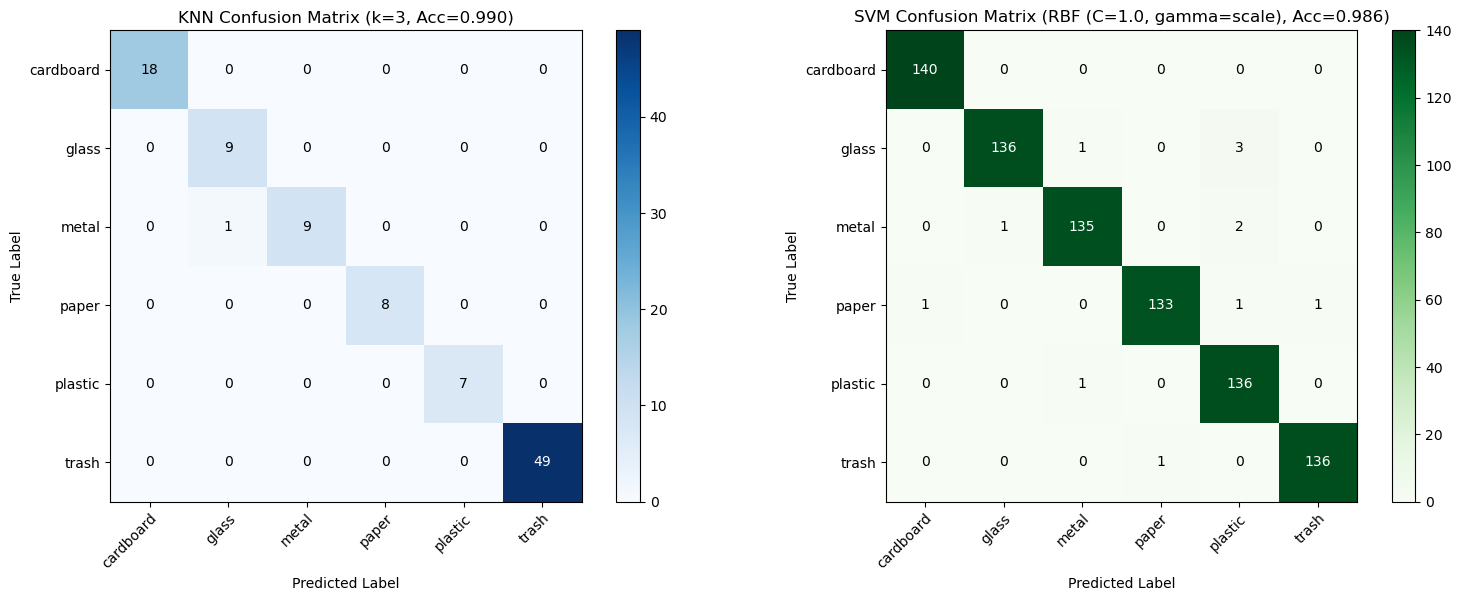

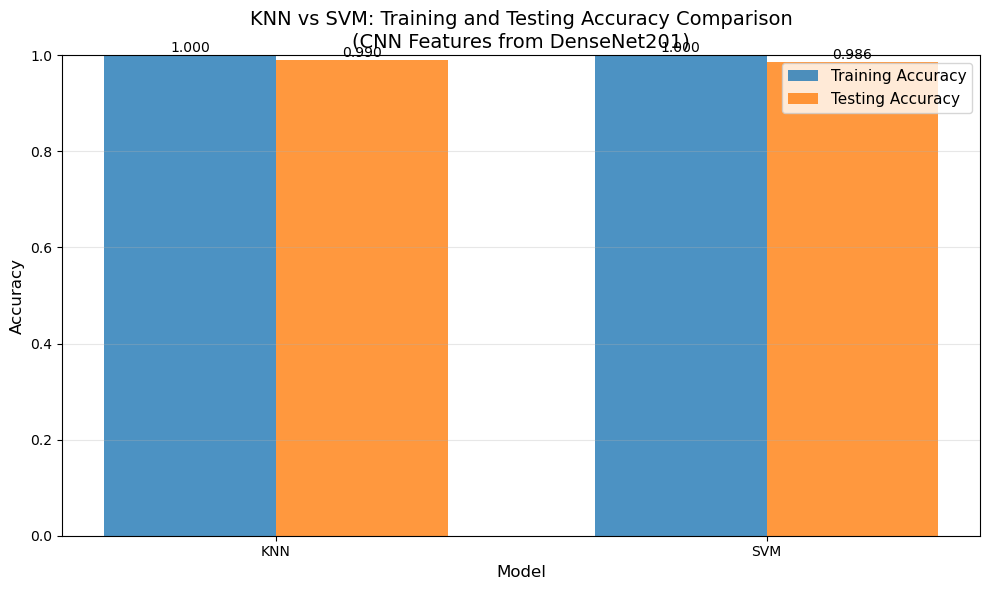


FINAL COMPARISON: KNN vs SVM
KNN (k=3):
  Training Accuracy: 1.0000 (100.00%)
  Testing Accuracy:  0.9901 (99.01%)

SVM (RBF (C=1.0, gamma=scale)):
  Training Accuracy: 1.0000 (100.00%)
  Testing Accuracy:  0.9855 (98.55%)

✓ KNN performs better by 0.46% on test set


In [31]:
# Compare KNN vs SVM
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: KNN Confusion Matrix
ax = axes[0]
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=le.classes_,
       yticklabels=le.classes_,
       title=f'KNN Confusion Matrix (k={best_k}, Acc={test_accuracy:.3f})',
       ylabel='True Label',
       xlabel='Predicted Label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Plot 2: SVM Confusion Matrix
ax = axes[1]
im = ax.imshow(cm_svm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm_svm.shape[1]),
       yticks=np.arange(cm_svm.shape[0]),
       xticklabels=le.classes_,
       yticklabels=le.classes_,
       title=f'SVM Confusion Matrix ({best_svm_result["name"]}, Acc={test_accuracy_svm:.3f})',
       ylabel='True Label',
       xlabel='Predicted Label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh_svm = cm_svm.max() / 2.
for i in range(cm_svm.shape[0]):
    for j in range(cm_svm.shape[1]):
        ax.text(j, i, format(cm_svm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_svm[i, j] > thresh_svm else "black")

plt.tight_layout()
plt.show()

# Plot accuracy comparison
fig, ax = plt.subplots(figsize=(10, 6))
models = ['KNN', 'SVM']
train_accs = [train_accuracy, train_accuracy_svm]
test_accs = [test_accuracy, test_accuracy_svm]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_accs, width, label='Training Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, test_accs, width, label='Testing Accuracy', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('KNN vs SVM: Training and Testing Accuracy Comparison\n(CNN Features from DenseNet201)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("FINAL COMPARISON: KNN vs SVM")
print("=" * 60)
print(f"KNN (k={best_k}):")
print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nSVM ({best_svm_result['name']}):")
print(f"  Training Accuracy: {train_accuracy_svm:.4f} ({train_accuracy_svm*100:.2f}%)")
print(f"  Testing Accuracy:  {test_accuracy_svm:.4f} ({test_accuracy_svm*100:.2f}%)")
print("=" * 60)

if test_accuracy_svm > test_accuracy:
    print(f"\n✓ SVM performs better by {(test_accuracy_svm - test_accuracy)*100:.2f}% on test set")
else:
    print(f"\n✓ KNN performs better by {(test_accuracy - test_accuracy_svm)*100:.2f}% on test set")